# How to use your own transforms in ClinicaDL?

The goal of this tutorial is to see how you can use your own transforms in ClinicaDL. This may interest you if you don't find what you want in [natively supported transforms](https://clinicadl.readthedocs.io/en/latest/transforms/transforms.html#supported-transforms) or in [ClinicaDL Transforms Zoo](https://github.com/aramis-lab/clinicadl-zoo).

## Introduction

As an example, we will implement a transform that generates hypointensities in a random mask on T1 MRI images.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchio as tio

from clinicadl.data.datasets import CapsDataset
from clinicadl.data.datatypes import T1Linear
from clinicadl.data.structures import DataPoint
from clinicadl.data.structures.examples import ColinDataPoint
from clinicadl.transforms import Transforms

Let's define some useful functions:

In [2]:
def random_mask(img: torch.Tensor) -> torch.Tensor:
    """
    Generates a random mask (a rectangular prism) for a 4D tensor
    (with one channel dimension).

    Parameters
    ----------
    img : torch.Tensor
        The image.

    Returns
    -------
    torch.Tensor
        A random mask for the image.
    """
    center = np.array(img.shape[1:]) // 2
    radius = np.random.randint(1, center)
    mask = np.zeros_like(img)
    mask[
        :,
        (center - radius)[0] : (center + radius)[0],
        (center - radius)[1] : (center + radius)[1],
        (center - radius)[2] : (center + radius)[2],
    ] = 1
    return torch.from_numpy(mask).bool()

def random_hypo_coeff(min_hypo: float = 0.5) -> float:
    """
    Generates a random hypointensity coefficient.

    Parameters
    ----------
    min_hypo : float (optional, default=0.5)
        The minimal coefficient. The random hypointensity coefficient
        will be sample randomly between 0 and ``min_hypo``.

    Returns
    -------
    float
        The hypointensity coefficient, i.e. the intensity reduction factor
        that will be applied in the mask.
    """
    return np.random.uniform(0, min_hypo)

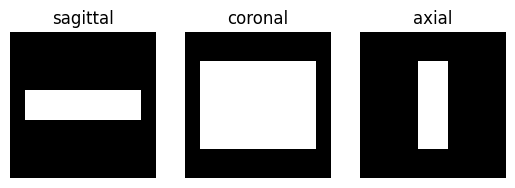

In [5]:
mask = random_mask(torch.randn(1, 10, 10, 10))

fig, axes = plt.subplots(1, 3)
axes[0].imshow(mask[0, 5], cmap="gray")
axes[0].set_title("sagittal")
axes[0].set_axis_off()
axes[1].imshow(mask[0, :, 5], cmap="gray")
axes[1].set_title("coronal")
axes[1].set_axis_off()
axes[2].imshow(mask[0, :, :, 5], cmap="gray")
axes[2].set_title("axial")
axes[2].set_axis_off()

Now, let's define our transform.

A transform compatible with ClinicaDL is a transform that inherits from [torchio.Transforms](https://torchio.readthedocs.io/transforms/transforms.html#torchio.transforms.Transform). 

You only need to overwrite the ``__init__``, where you define your parameters (don't forget to define the list of these parameters is ``self.arg_names``), and the method ``apply_transform``, where you actually compute the transform.

This latter must take as input and return a [DataPoint](https://clinicadl.readthedocs.io/en/latest/data/datapoint.html#clinicadl.data.structures.DataPoint). Inside, feel free to use the useful methods of DataPoint to compute your transforms. You will likely be particularly interested in ``get_images``, that enables you to iterate on all the images and masks in the DataPoint.

PS: don't forget to call ``super().__init__()``!

In [3]:
class RandomHypoIntensity(tio.Transform):
    """
    To generate random hypointensities in ClinicaDL.
    """

    def __init__(self, min_hypo: float = 0.5, **kwargs):
        super().__init__(**kwargs)
        self.min_hypo = min_hypo
        self.args_names = ["min_hypo"]

    def apply_transform(self, datapoint: DataPoint) -> DataPoint:
        mask = random_mask(datapoint.image.tensor)
        hypo_coeff = random_hypo_coeff(self.min_hypo)

        # apply the hypointensity to all the images in DataPoint (but not the masks because intensity_only=True)
        for image in datapoint.get_images(intensity_only=True):
            tensor = image.tensor
            tensor[mask] *= hypo_coeff
            image.set_data(tensor)

        return datapoint

Let's try our transform:

In [9]:
transform = RandomHypoIntensity()
datapoint = ColinDataPoint()
transformed = transform(datapoint)

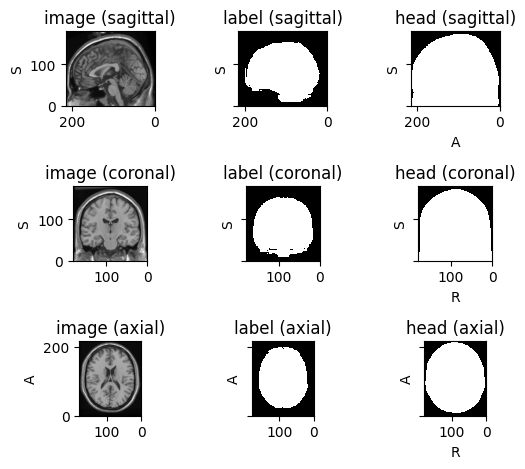

In [7]:
datapoint.plot()

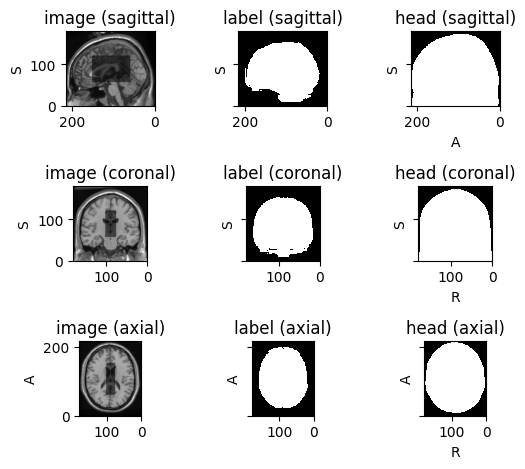

In [10]:
transformed.plot()

Ok, now let's see if it works with ClinicaDL's [CapsDataset](https://clinicadl.readthedocs.io/en/latest/data/caps_datasets.html).

Let's download the CAPS structure on which we will work:

In [11]:
!curl -k https://aramislab.paris.inria.fr/clinicadl/files/handbook_2023/data_oasis/CAPS_example.tar.gz -o CAPS_example.tar.gz
!tar xf CAPS_example.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  335M  100  335M    0     0  66.6M      0  0:00:05  0:00:05 --:--:-- 70.1M 0:00:07 45.5M


In [12]:
caps = CapsDataset(
    caps_directory="data_oasis/CAPS_example",
    preprocessing=T1Linear(),
    transforms=Transforms(
        image_transforms=[RandomHypoIntensity()],
    ),
)
caps.to_tensors("t1_conversion", save_transforms=False)     # conversion to tensors is necessary to manipulate data in a CapsDataset

Creating a TSV file at data_oasis/CAPS_example/overview_t1-linear_cropped.tsv


Converting images and image-specific masks: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]
Converting common masks: 0it [00:00, ?it/s]


In [23]:
out = caps[0]
out

DataPoint(Keys: ('image', 'label', 'participant', 'session', 'image_path', 'preprocessing', 'extraction', 'sample_index'); images: 1)

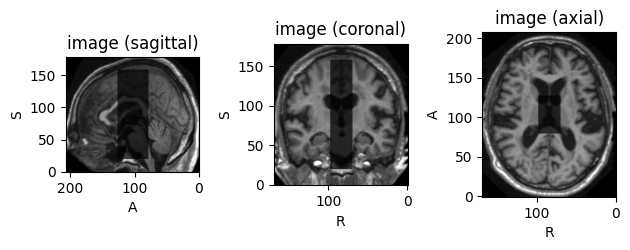

In [24]:
out.plot()

Our transform has effectively been applied to the data! We can also see that by calling the method ``get_applied_transforms``.

In [26]:
out.get_applied_transforms()

[RandomHypoIntensity(min_hypo=0.5)]

Now, we would like to keep track of the mask used to generate the hypointensity, as well as the hypointensity coefficient. To do this, we need to modify our transform to add some information in the  output ``DataPoint``.

## Add information to a ``DataPoint``

In [33]:
class RandomHypoIntensity(tio.Transform):
    """
    To generate random hypointensities in ClinicaDL.
    """

    def __init__(self, min_hypo: float = 0.5, **kwargs):
        super().__init__(**kwargs)
        self.min_hypo = min_hypo
        self.args_names = ["min_hypo"]

    def apply_transform(self, datapoint: DataPoint) -> DataPoint:
        mask = random_mask(datapoint.image.tensor)
        hypo_coeff = random_hypo_coeff(self.min_hypo)

        # apply the hypointensity to all the images in DataPoint (but not the masks because intensity_only=True)
        for image in datapoint.get_images(intensity_only=True):
            tensor = image.tensor
            tensor[mask] *= hypo_coeff
            image.set_data(tensor)

        ### save useful data ###
        datapoint.add_image(datapoint.image, "original_image")
        datapoint.add_mask(
            tio.LabelMap(tensor=mask, affine=datapoint.image.affine), "random_mask"
        )
        datapoint["hypo_coeff"] = hypo_coeff
        ######

        return datapoint

In [34]:
caps = CapsDataset(
    caps_directory="data_oasis/CAPS_example",
    preprocessing=T1Linear(),
    data="data_oasis/CAPS_example/overview_t1-linear_cropped.tsv",
    transforms=Transforms(
        image_transforms=[RandomHypoIntensity()],
    ),
)
caps.read_tensor_conversion("t1_conversion")

In [35]:
out = caps[0]
out

DataPoint(Keys: ('image', 'label', 'participant', 'session', 'image_path', 'preprocessing', 'original_image', 'random_mask', 'hypo_coeff', 'extraction', 'sample_index'); images: 3)

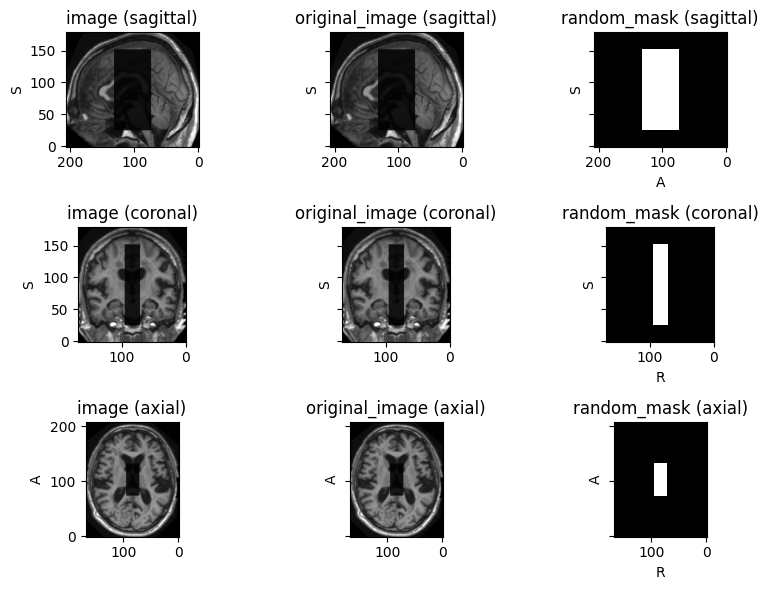

In [36]:
out.plot(figsize=(12,6))

In [37]:
out["hypo_coeff"]

0.150210026696055

We have indeed modified the output of our CapsDataset via a transform!

The last thing we need to mention is how conversion to tensors is affected when you pass your own transform...

## Custom transform and conversion to tensors

Reminder: a **CapsDataset only works with ``.pt`` files**. So, before manipulating data you need to convert them to tensors. Instead of raw tensor images, you may want to save transformed images, to speed up data processing.

In [38]:
caps = CapsDataset(
    caps_directory="data_oasis/CAPS_example",
    preprocessing=T1Linear(),
    data="data_oasis/CAPS_example/overview_t1-linear_cropped.tsv",
    transforms=Transforms(
        image_transforms=[RandomHypoIntensity()],
    ),
)
caps.to_tensors("t1_with_transforms", save_transforms=True)

Converting images and image-specific masks:   0%|          | 0/4 [00:00<?, ?it/s]

Converting images and image-specific masks: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]
Converting common masks: 0it [00:00, ?it/s]
/Users/thibault.devarax/Desktop/code/clinicadl/clinicadl/data/tensor_conversion.py:715: UserWarning: The following (participant, session) have already been converted:
   * (sub-OASIS10109, ses-M000)
   * (sub-OASIS10016, ses-M000)
   * (sub-OASIS10304, ses-M000)
   * (sub-OASIS10363, ses-M000)
The old tensors will be overwritten.
  warnings.warn(warning_message)


Here, you saved transformed images. The next time you want to use them, you will call ``read_tensor_conversion``.

In [39]:
caps = CapsDataset(
    caps_directory="data_oasis/CAPS_example",
    preprocessing=T1Linear(),
    data="data_oasis/CAPS_example/overview_t1-linear_cropped.tsv",
    transforms=Transforms(
        image_transforms=[RandomHypoIntensity()],
    ),
)
caps.read_tensor_conversion("t1_with_transforms")

ClinicaDLTensorConversionError: Custom transforms have been used during the conversion associated to 'data_oasis/CAPS_example/tensor_conversion/t1_with_transforms.json', e.g.: 'Custom transform passed by the user: 'RandomHypoIntensity''.
ClinicaDL cannot read such custom transforms. For ClinicaDL to be able to read tensor conversion json files, use only transforms implemented in ClinicaDL (see our documentation to know these transforms).
If you are sure that the transforms match, set 'check_transforms' to False.

Here, we have an issue: as we used transforms not natively supported, ClinicaDL cannot read them and compare them to the current transforms. To overcome this issue, **if you are sure that the transforms you used when saving tensors are the same as the current ones**, set ``check_transforms=False``:

In [40]:
caps.read_tensor_conversion("t1_with_transforms", check_transforms=False)
out = caps[0]
out

DataPoint(Keys: ('image', 'label', 'participant', 'session', 'image_path', 'preprocessing', 'extraction', 'sample_index'); images: 1)

However, we can see that we miss here the additional elements added to the DataPoint in [our transform](#add-information-to-a-datapoint) ('original_image', 'random_mask' and 'hypo_coeff'). This is because, by default, CapsDataset will only load the elements it needs in the ``.pt`` files (the image and potentially some masks, passed via the argument ``masks`` of the CapsDataset), even if the additional data we want is indeed in the ``.pt`` files:

In [41]:
pt_file = torch.load("data_oasis/CAPS_example/subjects/sub-OASIS10016/ses-M000/t1_linear/tensors/sub-OASIS10016_ses-M000_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt")
pt_file.keys()

dict_keys(['image', 'label', 'original_image', 'random_mask', 'hypo_coeff', 'affine'])

To overcome this issue, simply use the argument ``load_also`` in ``read_tensor_conversion``:

In [42]:
caps.read_tensor_conversion(
    "t1_with_transforms",
    check_transforms=False,
    load_also=["original_image", "random_mask", "hypo_coeff"],
)
caps[0]

DataPoint(Keys: ('image', 'label', 'participant', 'session', 'image_path', 'preprocessing', 'original_image', 'random_mask', 'hypo_coeff', 'extraction', 'sample_index'); images: 3)

### Last remarks

1. You will not have such issues if you don't save transformed images (``save_transforms=False``). The drawback is that you will compute the transforms every time you load the data. So, there is a tradeoff between efficiency and simplicity. It's up to you to decide!

In [43]:
caps = CapsDataset(
    caps_directory="data_oasis/CAPS_example",
    preprocessing=T1Linear(),
    data="data_oasis/CAPS_example/overview_t1-linear_cropped.tsv",
    transforms=Transforms(
        image_transforms=[RandomHypoIntensity()],
    ),
)
caps.to_tensors("t1_conversion", save_transforms=False)

Converting images and image-specific masks: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]
Converting common masks: 0it [00:00, ?it/s]
/Users/thibault.devarax/Desktop/code/clinicadl/clinicadl/data/tensor_conversion.py:715: UserWarning: The following (participant, session) have already been converted:
   * (sub-OASIS10109, ses-M000)
   * (sub-OASIS10016, ses-M000)
   * (sub-OASIS10304, ses-M000)
   * (sub-OASIS10363, ses-M000)
The old tensors will be overwritten.
  warnings.warn(warning_message)


In [44]:
caps = CapsDataset(
    caps_directory="data_oasis/CAPS_example",
    preprocessing=T1Linear(),
    data="data_oasis/CAPS_example/overview_t1-linear_cropped.tsv",
    transforms=Transforms(
        image_transforms=[RandomHypoIntensity()],
    ),
)
caps.read_tensor_conversion("t1_conversion")
caps[0]

DataPoint(Keys: ('image', 'label', 'participant', 'session', 'image_path', 'preprocessing', 'original_image', 'random_mask', 'hypo_coeff', 'extraction', 'sample_index'); images: 3)

2. These issues arise only if you pass image transforms. In the case where you only pass sample transforms, there's no question about it since samples are not saved:

In [45]:
from clinicadl.transforms.extraction import Patch

caps = CapsDataset(
    caps_directory="data_oasis/CAPS_example",
    preprocessing=T1Linear(),
    data="data_oasis/CAPS_example/overview_t1-linear_cropped.tsv",
    transforms=Transforms(
        extraction=Patch(patch_size=16, stride=16),
        image_transforms=[],
        sample_transforms=[RandomHypoIntensity()],
    ),
)
caps.to_tensors("t1_conversion")

Converting images and image-specific masks: 0it [00:00, ?it/s]
Converting common masks: 0it [00:00, ?it/s]


In [46]:
caps = CapsDataset(
    caps_directory="data_oasis/CAPS_example",
    preprocessing=T1Linear(),
    data="data_oasis/CAPS_example/overview_t1-linear_cropped.tsv",
    transforms=Transforms(
        extraction=Patch(patch_size=16, stride=16),
        image_transforms=[],
        sample_transforms=[RandomHypoIntensity()],
    ),
)
caps.read_tensor_conversion("t1_conversion")
caps[0]

DataPoint(Keys: ('image', 'label', 'participant', 'session', 'image_path', 'preprocessing', 'extraction', 'sample_index', 'patch_index', 'patch_size', 'patch_stride', 'original_image', 'random_mask', 'hypo_coeff'); images: 3)